In [1]:
import comet_ml as comet 
import os

import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

os.environ["COMET_API_KEY"] = "Z7zhSkfHKCsYmlZcaG8x5ssqJ"
API = comet.API()

In [2]:
metrics = {
    "avgF1 (No HTL)": float,
    "avgF1 (With HTL)": float,
    "avgF1 (random replacement)": float,
    "medF1 (No HTL)": float,
    "medF1 (With HTL)": float,
    "medF1 (random replacement)": float,
    "HTL Count": float,
    "ASO-Sig[1]": float,
    "ASO-Sig[2]": float,
    "HTL_harms_median": float,
    "HTL_low_val_median": float,
    "avg_duration": float,
}
parameters = {
    "strategy_name": str,
    "filter_strategy_name": str,
    "seed": int,
    "task_config":str,
}

task_names = [
    "ag-news",
    "dbpedia",
    "fnc1",
    "imdb",
    "qnli",
    "rotten-tomatoes",
    "sst2",
    #"trec-coarse",
    "trec",
    "wiki-talk",
]
version = "x"
task_names = [version+t for t in task_names]

seed_count = 15 # How many different seeds do we expect?

# Tasks that require a higher budget to run effectively even with AL
xl_task_names = [ 
    "xbanking77",
    "xmnli",
    "xyelp",
    
]

asset_names = [
    "random.npy", 
    "no_htl.npy", 
    "htl.npy", 
    "durations.npy"
]

filter_names = [
    "AutoFilter_LSTM_SIMPLE",
    "AutoFilter_LSTM",
    "AutoFilter_Chen_Like",
    "LoserFilter_Plain",
    "LoserFilter_Optimized_Pseudo_Labels",
    "LoserFilter_SSL_Variety",
    "TeachingFilter",
    "TeachingFilter_WOW",
    "TeachingFilter_Smooth",
    "SingleStepEntropy_SimplePseudo",
    "SingleStepEntropy",
]

In [3]:
# TODO REmove Runs with same seed and always the older one if both are complete
def load_experiment_data(experiment: comet.APIExperiment):
    data = {}
    for metric_name in metrics.keys():
        d = experiment.get_metrics(metric_name)
        if not d:
            return None
        else:
            data[metric_name] = d[0]["metricValue"]
    for param_name in parameters.keys():
        d = experiment.get_parameters_summary(param_name)
        if not d:
            return None
        else:
            data[param_name] = d["valueCurrent"]
    assets = download_assets(experiment, asset_names)
    for asset_name, asset in assets.items():
        data[asset_name] = asset
    return data

def load_workspace_data(project_name):
    experiments = API.get(workspace="jimmy-ml", project_name=project_name)
    experiment_data = []
    for exp in experiments:
        data = load_experiment_data(exp)
        if data is not None:
            experiment_data.append(data)
    
    df = pd.DataFrame(experiment_data)
    for col in df.columns:
        if col in metrics:
            df[col] = df[col].astype(metrics[col])
        elif col in parameters:
            df[col] = df[col].astype(parameters[col])
    #df_ = df[df["HTL Count"]>0]
    return df


def download_assets(experiment, asset_names):
    assets = experiment.get_asset_list()
    asset_ids = []
    for asset in assets:
        if asset["fileName"] in asset_names:
            asset_ids.append((asset["fileName"], asset["assetId"]))
    assets_downloaded = {}
    for file_name, idx in asset_ids:
        asset_data = experiment.get_asset(idx)
        asset_path = Path(f"./cache/assets/{file_name}")
        with open(asset_path, "wb") as f:
            f.write(asset_data)
        assets_downloaded[file_name[:-4]] = np.load(asset_path)
    return assets_downloaded


#df = load_workspace_data("xsst2")
#df

In [4]:
def concatenate_arrays(group):
    return np.concatenate(group.tolist())

dataframes = []
counts = []

def load_data(workspace_name):
    df = load_workspace_data(workspace_name)
    # Drop Same Seed Same Strategy (Duplicates)
    df_ = df.drop_duplicates(subset=['seed', 'filter_strategy_name'], keep='first')
    def process_group(group):
        missing_seeds = np.setdiff1d(np.arange(42,42+seed_count),np.array(group["seed"]))
        filter = list(group["filter_strategy_name"])[0]
        task = list(group["task_config"])[0]
        df = pd.DataFrame([{"seed":seed, "filter":filter, "task": task} for seed in missing_seeds])
        dataframes.append(df)
        print(len(missing_seeds))
        counts.append(len(missing_seeds))
        if len(group) < seed_count:
            print(f"Warning: Group '{filter}' in workspace {workspace_name} has only {len(group)} rows.")
        elif len(missing_seeds) > 0:
            pass
        return group.nsmallest(seed_count, 'seed')
    
    df_ = df_.groupby('filter_strategy_name').apply(process_group).reset_index(drop=True)
    tmp_dict = {}
    df_ = df_.groupby('filter_strategy_name')
    for asset in asset_names:
        asset_name = asset[:-4]
        tmp_dict[asset_name] = df_[asset_name].agg(concatenate_arrays)
    df_ = df_.mean(numeric_only=True)
    for key in tmp_dict.keys():
        df_[key] = tmp_dict[key]
    return df_


#load_data("xag-news")

In [5]:
results = {}
for task in tqdm(task_names):#[-2:]):
    try:
        results[task] = load_data(task)
    except:
        print(f"{task}: Missing")
    
missing_experiments = pd.concat(dataframes)

missing_experiments = missing_experiments[missing_experiments["filter"].isin(filter_names)]
missing_experiments.to_csv("missing_experiments.csv")
print(sum(counts))
missing_experiments # 941, 856, 848, 762, 747, (191)

  0%|          | 0/9 [00:00<?, ?it/s]

0
0
0
0
0
0
0
0
0
0
0
0
0
0
2
1
0
0
0
0
0
0
0
1
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
14
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
1
1
1
1
1
1
1
1
0
0
0
0
0
0
0
0
0
0
0
30


,seed,filter,task
0,55,LoserFilter_Optimized_Pseudo_Labels,./Configs/Tasks/dbpedia.json
1,56,LoserFilter_Optimized_Pseudo_Labels,./Configs/Tasks/dbpedia.json
0,55,LoserFilter_Plain,./Configs/Tasks/dbpedia.json
0,54,AutoFilter_LSTM,./Configs/Tasks/fnc_one.json
0,55,LoserFilter_Optimized_Pseudo_Labels,./Configs/Tasks/fnc_one.json
0,50,AutoFilter_Chen_Like,./Configs/Tasks/trec.json
0,50,AutoFilter_LSTM,./Configs/Tasks/trec.json
0,50,AutoFilter_LSTM_SIMPLE,./Configs/Tasks/trec.json
0,50,LoserFilter_Optimized_Pseudo_Labels,./Configs/Tasks/trec.json
0,50,LoserFilter_Plain,./Configs/Tasks/trec.json


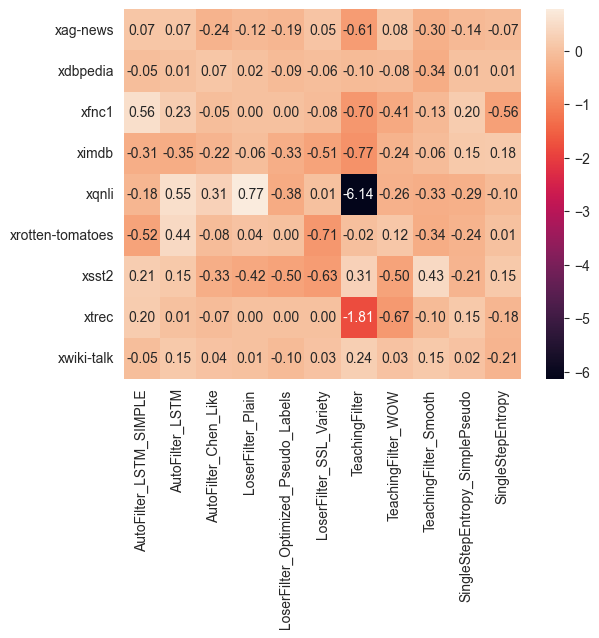

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize an empty matrix for storing Jaccard coefficients
gain_loss_matrix = np.zeros((len(task_names), len(filter_names)))

for i, task in enumerate(task_names):
    for j, filter in enumerate(filter_names):
        gain_loss_matrix[i, j] = (results[task]["avgF1 (No HTL)"][filter] - results[task]["avgF1 (With HTL)"][filter])*100

# Using seaborn for a nicer heatmap
sns.heatmap(gain_loss_matrix, annot=True, fmt=".2f", xticklabels=filter_names, yticklabels=task_names)
plt.rcParams.update({'font.size': 12})
#plt.title('Jaccard Coefficients Heatmap (All Datasets)')
#plt.xticks(fontsize=18)
#plt.yticks(fontsize=18)
plt.savefig("NoHTLChange.pdf", bbox_inches='tight')
plt.show()

In [7]:
missing_experiments[missing_experiments["filter"].isin(filter_names)]
results[task]

,avgF1 (No HTL),avgF1 (With HTL),avgF1 (random replacement),medF1 (No HTL),medF1 (With HTL),medF1 (random replacement),HTL Count,ASO-Sig[1],ASO-Sig[2],HTL_harms_median,HTL_low_val_median,avg_duration,seed,random,no_htl,htl,durations
filter_strategy_name,,,,,,,,,,,,,,,,,
AutoFilter_Chen_Like,0.919608,0.919177,0.920199,0.921330,0.920973,0.921441,37.866667,0.793280,0.683192,0.000357,0.000467,58.341039,49.0,"[0.9172215449060614, 0.9218481352965082, 0.915...","[0.8909468879927475, 0.9048110287911469, 0.930...","[0.9305855137703586, 0.9198630779330395, 0.905...","[3.337860107421875e-05, 2.6941299438476562e-05..."
AutoFilter_LSTM,0.919682,0.918231,0.919921,0.921247,0.919971,0.921147,2.200000,0.689889,0.657126,0.001276,0.001175,470.221408,49.0,"[0.9115633499015287, 0.8878208134046078, 0.928...","[0.9297102128856795, 0.887289380724624, 0.9308...","[0.9146894244896683, 0.9086873612804401, 0.934...","[140.53301310539246, 140.55504441261292, 140.4..."
AutoFilter_LSTM_SIMPLE,0.918363,0.918905,0.918951,0.921234,0.921086,0.921268,5.533333,0.879913,0.801729,0.000148,0.000182,109.795538,49.0,"[0.890352933821001, 0.8964018881490512, 0.9040...","[0.9248960580199443, 0.9301791240739004, 0.926...","[0.8968395385913908, 0.8930726187126825, 0.905...","[1865.3314621448517, 15.317091464996338, 15.19..."
LoserFilter_Optimized_Pseudo_Labels,0.919486,0.920442,0.920101,0.921911,0.922962,0.922258,1.000000,1.000000,0.912187,-0.001051,-0.000704,590.808948,49.0,"[0.8979336646972397, 0.937869267560724, 0.9201...","[0.9244271468317234, 0.902841601800619, 0.9087...","[0.9253649692081654, 0.9317109006220888, 0.924...","[140.49996733665466, 140.37961149215698, 140.4..."
LoserFilter_Plain,0.919559,0.919482,0.919391,0.922083,0.921520,0.921341,3.466667,0.857100,0.880063,0.000563,-0.000179,621.703781,49.0,"[0.9266935509081247, 0.9127199974991403, 0.928...","[0.9352902560255087, 0.9349776485666949, 0.922...","[0.9263965738222514, 0.9308199693644691, 0.928...","[140.5432801246643, 140.46304965019226, 140.43..."
LoserFilter_SSL_Variety,0.918815,0.918482,0.918863,0.921929,0.922302,0.922077,12.533333,0.812310,0.894913,-0.000373,-0.000225,4395.893579,49.0,"[0.93128888055269, 0.9235362155741036, 0.92084...","[0.9278658288786771, 0.923051674012942, 0.9285...","[0.9313514020444528, 0.9226921754353059, 0.935...","[140.50193047523499, 140.49106431007385, 140.4..."
SingleStepEntropy,0.918608,0.920677,0.919945,0.921217,0.922307,0.921204,11.533333,0.824307,0.825246,-0.001090,-0.001102,1082.053334,49.0,"[0.9222857857388477, 0.9257244677858013, 0.914...","[0.9333520897808621, 0.917971802807215, 0.9107...","[0.9275375910469223, 0.9112663728156554, 0.913...","[140.29963517189026, 140.43710136413574, 140.3..."
SingleStepEntropy_SimplePseudo,0.919078,0.918830,0.920659,0.921215,0.920910,0.922429,11.733333,0.732025,0.659842,0.000305,0.001518,1066.113186,49.0,"[0.9218168745506268, 0.906780455781675, 0.9016...","[0.9142674044202694, 0.9277407858951514, 0.902...","[0.9376035512207321, 0.9027790803088561, 0.921...","[140.31165289878845, 140.29811882972717, 140.3..."
TeachingFilter,0.920566,0.918128,0.918031,0.922059,0.919557,0.919961,245.400000,0.536437,0.773191,0.002502,0.000403,140.931200,49.0,"[0.9186126480977836, 0.9331176341867516, 0.916...","[0.9288818031198225, 0.9174872612460533, 0.927...","[0.9226296539435431, 0.9377442245771984, 0.931...","[140.55178308486938, 140.51614570617676, 140.5..."


In [8]:
'''for filter_name in filter_names:
    data = []
    for task in task_names:
        data.append(results[task]["htl"][filter_name])
        data.append(results[task]["no_htl"][filter_name])
    fig, ax = plt.subplots()

    # Creating boxplot with pairs close together
    positions = [pos for i in range(len(task_names)) for pos in (i*3, i*3+1)]  
    ax.boxplot(data, positions=positions, showfliers=False)
    
    # Adding labels and title for clarity
    ax.set_title(filter_name)
    ax.set_xlabel("Datasets")
    ax.set_ylabel('F1')
    plt.show()'''

'for filter_name in filter_names:\n    data = []\n    for task in task_names:\n        data.append(results[task]["htl"][filter_name])\n        data.append(results[task]["no_htl"][filter_name])\n    fig, ax = plt.subplots()\n\n    # Creating boxplot with pairs close together\n    positions = [pos for i in range(len(task_names)) for pos in (i*3, i*3+1)]  \n    ax.boxplot(data, positions=positions, showfliers=False)\n    \n    # Adding labels and title for clarity\n    ax.set_title(filter_name)\n    ax.set_xlabel("Datasets")\n    ax.set_ylabel(\'F1\')\n    plt.show()'

In [9]:
import deepsig
import pandas as pd
aso_test = {}
for filter_name in filter_names:
    data = []
    task_aso = {}
    for task in task_names:
        htl = results[task]["htl"][filter_name]
        no_htl = results[task]["no_htl"][filter_name]
        replacement = results[task]["random"][filter_name]
        better = deepsig.aso(no_htl, htl, seed=42, num_bootstrap_iterations=2500)
        worse = deepsig.aso(htl, no_htl, seed=42, num_bootstrap_iterations=2500)
        somewhat_better = deepsig.aso(replacement, htl, seed=42, num_bootstrap_iterations=2500)
        somewhat_worse = deepsig.aso(htl, replacement, seed=42, num_bootstrap_iterations=2500)
        task_aso[task+"_no_htl_is_better"] = better
        task_aso[task+"_random_is_better"] = somewhat_better
        task_aso[task+"_no_htl_is_worse"] = worse
        task_aso[task+"_random_is_worse"] = somewhat_worse
    aso_test[filter_name] = task_aso
    
pd.DataFrame(aso_test)    

Bootstrap iterations: 100%|█████████▉| 2499/2500 [00:38<00:00, 64.94it/s]
C:\Users\Jimmy\Documents\UNI\Projects\ThoroughOracle\venv_9v_simple\Lib\site-packages\deepsig\aso.py:390: UserWarning: Division by zero encountered in violation ratio.
  warn("Division by zero encountered in violation ratio.")
Bootstrap iterations: 100%|█████████▉| 2499/2500 [00:37<00:00, 66.93it/s]


,AutoFilter_LSTM_SIMPLE,AutoFilter_LSTM,AutoFilter_Chen_Like,LoserFilter_Plain,LoserFilter_Optimized_Pseudo_Labels,LoserFilter_SSL_Variety,TeachingFilter,TeachingFilter_WOW,TeachingFilter_Smooth,SingleStepEntropy_SimplePseudo,SingleStepEntropy
xag-news_no_htl_is_better,0.369509,0.586198,0.994616,1.000000,1.000000,0.539069,1.000000,0.402503,1.000000,0.868859,1.000000
xag-news_random_is_better,0.133856,0.168150,0.096331,0.539611,0.839322,0.388600,0.894785,0.228868,0.513823,0.235273,0.942500
xag-news_no_htl_is_worse,1.000000,1.000000,0.192868,0.181143,0.621255,1.000000,0.034610,0.980235,0.078605,0.269407,0.474343
xag-news_random_is_worse,1.000000,1.000000,1.000000,0.720295,0.975935,1.000000,0.448442,0.952756,1.000000,1.000000,0.405452
xdbpedia_no_htl_is_better,1.000000,0.585530,0.531515,0.616561,1.000000,1.000000,1.000000,1.000000,1.000000,0.665538,0.509434
xdbpedia_random_is_better,1.000000,0.471187,0.034501,0.347230,0.266923,0.055356,0.303431,0.337634,0.219370,0.369297,1.000000
xdbpedia_no_htl_is_worse,0.712198,0.737037,1.000000,0.744678,0.441471,0.813967,0.263273,0.407723,0.067617,1.000000,0.856454
xdbpedia_random_is_worse,1.000000,0.887226,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.900159
xfnc1_no_htl_is_better,0.292015,0.586823,1.000000,1.000000,1.000000,1.000000,0.857752,1.000000,0.814700,0.184640,0.696592
xfnc1_random_is_better,0.419204,0.774435,0.189615,1.000000,1.000000,0.444384,0.000335,1.000000,0.165397,0.094170,0.194289


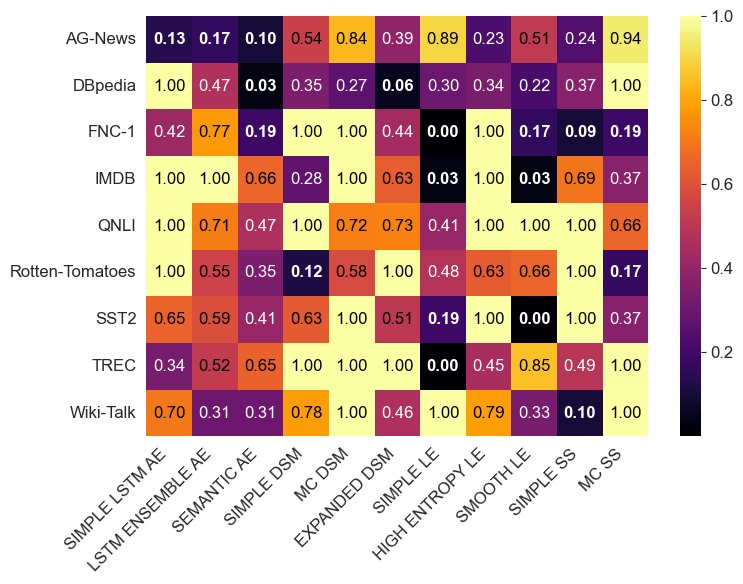

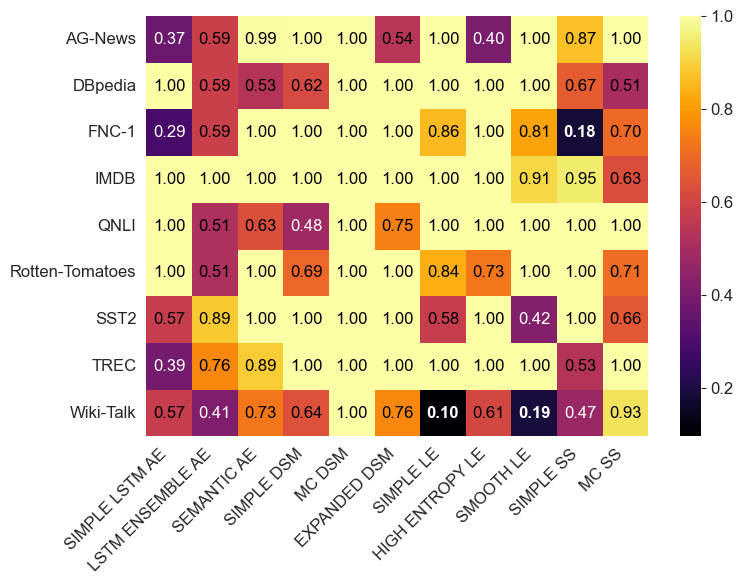

In [38]:
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
row_ident = '_random_is_better'

filter_names_ = [
    "AutoFilter_LSTM_SIMPLE",
    "AutoFilter_LSTM",
    "AutoFilter_Chen_Like",
    "LoserFilter_Plain",
    "LoserFilter_Optimized_Pseudo_Labels",
    "LoserFilter_SSL_Variety",
    "TeachingFilter",
    "TeachingFilter_WOW",
    "TeachingFilter_Smooth",
    "SingleStepEntropy_SimplePseudo",
    "SingleStepEntropy",
]

filter_names_clean = {
    "LoserFilter_SSL_Variety": "EXPANDED DSM", 
    "LoserFilter_Plain": "SIMPLE DSM",
    "LoserFilter_Optimized_Pseudo_Labels": "MC DSM", 
    "AutoFilter_Chen_Like": "SEMANTIC AE", 
    "AutoFilter_LSTM": "LSTM ENSEMBLE AE",
    "AutoFilter_LSTM_SIMPLE": "SIMPLE LSTM AE", 
    "SingleStepEntropy": "MC SS", 
    "SingleStepEntropy_SimplePseudo": "SIMPLE SS",
    "TeachingFilter": "SIMPLE LE", 
    "TeachingFilter_Smooth": "SMOOTH LE", 
    "TeachingFilter_WOW": "HIGH ENTROPY LE"}

ds_names_clean = {
    "xag-news": "AG-News",
    "xdbpedia": "DBpedia",
    "xfnc1": "FNC-1",
    "ximdb": "IMDB",
    "xqnli": "QNLI",
    "xrotten-tomatoes": "Rotten-Tomatoes",
    "xsst2": "SST2",
    "xtrec": "TREC",
    "xwiki-talk": "Wiki-Talk"
}


def create_heatmap(aso_test, row_ident):
    df = pd.DataFrame(aso_test)    
    df = df[df.index.str.contains(row_ident)]
    df = df.transpose().sort_index().transpose()
    
    # Threshold for bolding numbers
    threshold = 0.20
    
    # Create the heatmap
    plt.figure(figsize=(8, 6))
    df = df[filter_names_]
    heatmap = sns.heatmap(df, cmap='inferno', norm=None)
    
    # Annotate the heatmap with text
    for i in range(df.shape[0]):
        for j, filter in enumerate(filter_names_):
            value = df.iloc[i, j]
            text_color = "white" if value < 0.5 else "black"
            weight = "bold" if value < threshold else "normal"
            plt.text(j+0.5, i+0.5, f'{value:.2f}', ha="center", va="center", color=text_color, fontweight=weight)
    
    plt.xticks(ticks=np.arange(df.shape[1])+0.5, labels=[filter_names_clean[f] for f in filter_names_], rotation=45, ha='right')
    plt.yticks(ticks=np.arange(df.shape[0])+0.5, labels=[ds_names_clean[row.replace(row_ident, '')] for row in df.index])
    
    #plt.colorbar(heatmap)
    #plt.title(row_ident)
    plt.tight_layout()
    plt.savefig(row_ident+"0.pdf")
    plt.show()
create_heatmap(aso_test, '_random_is_better')
create_heatmap(aso_test, '_no_htl_is_better')

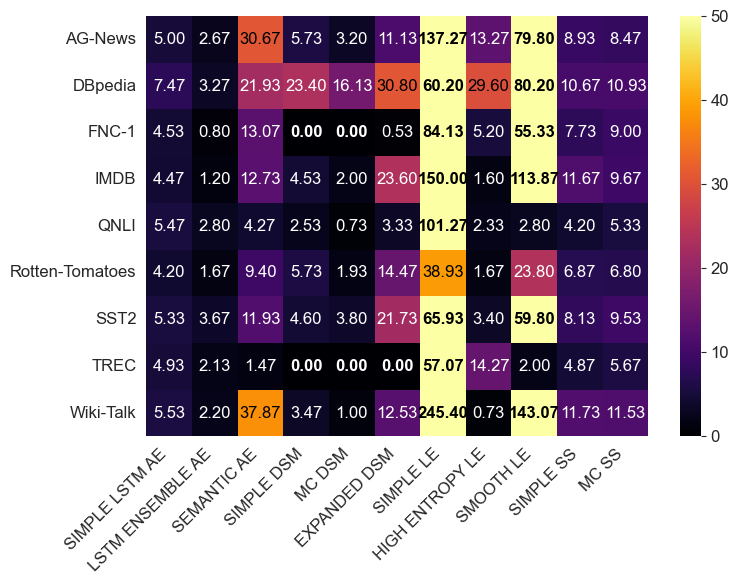

In [59]:
pd.DataFrame([results[task]["HTL Count"] for task in results.keys()])
df = pd.DataFrame({task: results[task]["HTL Count"] for task in task_names})
df = df.drop(["RandomFilter"])
df = df.transpose()
df = df[filter_names_]
df = df.rename({"filter_strategy_name": ""})
threshold = 0.25
norm = Normalize(vmin=0, vmax=50)

# Create the heatmap
plt.figure(figsize=(8, 6))
heatmap = sns.heatmap(df, cmap='inferno', norm=norm)

# Annotate the heatmap with text
for i in range(df.shape[0]):
    for j in range(df.shape[1]):
        value = df.iloc[i, j]
        text_color = "white" if value < 25 else "black"
        weight = "bold" if value <= 0 or value > 50 else "normal"
        plt.text(j+0.5, i+0.5, f'{value:.2f}', ha="center", va="center", color=text_color, fontweight=weight)

plt.xticks(ticks=np.arange(df.shape[1])+0.5, labels=[filter_names_clean[f] for f in df.columns], rotation=45, ha='right')
plt.yticks(ticks=np.arange(df.shape[0])+0.5, labels=[ds_names_clean[row.replace(row_ident, '')] for row in df.index])

#plt.colorbar(heatmap)
#plt.title("Identified HTL Count")
heatmap.set_xlabel('')
plt.tight_layout()
plt.savefig("IdentifiedHTLCount.pdf")
plt.show()

In [67]:
runtime_results = []
for filter in filter_names_:
    d = results[task]['durations'][filter]
    min_ = min(d)
    max_ = max(d)
    med = np.median(d)
    avg = np.mean(d)
    runtime_results.append({
        "Name": filter_names_clean[filter],
        "Min": min_,
        "Max": max_,
        "Median": med,
        "Mean": avg,
    })
print(pd.DataFrame(runtime_results).to_latex())

\begin{tabular}{llrrrr}
\toprule
 & Name & Min & Max & Median & Mean \\
\midrule
0 & SIMPLE LSTM AE & 15.090934 & 2514.706236 & 15.402484 & 109.795538 \\
1 & LSTM ENSEMBLE AE & 140.243325 & 5563.148839 & 233.715970 & 470.221408 \\
2 & SEMANTIC AE & 0.000016 & 1197.165140 & 0.000029 & 58.341039 \\
3 & SIMPLE DSM & 140.279600 & 1030.067234 & 666.398485 & 621.703781 \\
4 & MC DSM & 140.183779 & 1034.435775 & 670.937095 & 590.808948 \\
5 & EXPANDED DSM & 140.283490 & 6085.797682 & 5822.869494 & 4395.893579 \\
6 & SIMPLE LE & 140.226446 & 145.076859 & 140.412990 & 140.931200 \\
7 & HIGH ENTROPY LE & 140.235213 & 214.821078 & 140.568499 & 140.989644 \\
8 & SMOOTH LE & 140.263567 & 153.631946 & 140.439853 & 141.323989 \\
9 & SIMPLE SS & 140.249756 & 1335.359154 & 1292.715315 & 1066.113186 \\
10 & MC SS & 140.274902 & 3911.346397 & 1288.915805 & 1082.053334 \\
\bottomrule
\end{tabular}


In [ ]:
df_ = df.groupby("strategy_name")
df_ = df_.mean(numeric_only=True)
df_["value"] = df_["HTL_low_val_median[2.1]"] + df_["HTL_harms_median[1.1]"]
df_["rank"] = df_['value'].rank()
# -Get Experiments
# -Download Data
# -Clean Data (No Double Seeds if double seeds take newest)
# -Check Data (at least 10 different Seeds) 
# -if more than 10 take lowest 10 seeds
# \if less write missing jobs to file
# Visualize Data (Julius Like) Every Strategy becomes one Graph
# Boxplot for each task in two executions with and without filter 
# Goal: With filter mean higher

In [ ]:
# Aggregatge & Simplify Data 
# e.g. how much changed the filter the mean in each exp -> Mean of this over all tasks 
# With and without no-HTL-Found-runs

In [ ]:
# ASO Test
# Download Specific Data for each experiment
# Combine Data 
# Do ASO Test